# Predicting Customer Churn

## Summary

The dataset consists of a telecom dataset with 7043 observations and 19 features. The goal of this analysis is to create a model that predicts customer churn while maximizing sensitivity, f1, and AUC. Sensitivity is the primary measurement to target as many accurate churns as possible. False positives are acceptable, but would preferably be minimized. With appropriate profit data these measurements may change.

In [33]:
import pandas as pd
import numpy as np

# model prep
from sklearn import cluster
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.model_selection import train_test_split
# !pip install prince
from prince import PCA
from statsmodels.regression import linear_model

# models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# model evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_predict

# visualization
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline
style.use('seaborn-white')
import seaborn as sns
sns.set_style('white')

# !pip install jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme = 'onedork', grid = False)

In [34]:
df = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

## Data Exploration & Prep

The TotalCharges feature has some missing values. These observations also have a tenure of 0, indicating new customers who may not have accumulated total charges yet. Therefore, I replaced the missing observations with 0.

The customerID field is not appropriate for creating a model since it's a unique identifier and may lead to overfitting.

None of the numerical features are normally distributed, which isn't a problem since none of the classification methods we're using require normality.

The numerical variables also do not have any outliers that need to be addressed.

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


While there are no null values in the dataset, as seen above, there are 11 blank values in **TotalCharges** whenever **tenure** is 0

In [36]:
print('Blanks in TotalCharges')
print(df.TotalCharges.str.isspace().value_counts())

print('\nTenure where TotalCharges is blank')
print(df[df.TotalCharges.str.isspace()][['tenure', 'TotalCharges']])

# clean missing values
# when TotalCharges is blank, the tenure is 0
df.TotalCharges = df.TotalCharges.replace(' ', '0')

# TotalCharges is read initially as a string because of the blank values. This field should be a float.
df.TotalCharges = pd.to_numeric(df.TotalCharges, downcast='float')

Blanks in TotalCharges
False    7032
True       11
Name: TotalCharges, dtype: int64

Tenure where TotalCharges is blank
      tenure TotalCharges
488        0             
753        0             
936        0             
1082       0             
1340       0             
3331       0             
3826       0             
4380       0             
5218       0             
6670       0             
6754       0             


The **customerID** field is a unique value that could lead to overfitting if included in the analysis. I've also removed **gender** from the analysis to avoid gender bias.

In [37]:
# customerID is a unique identifier that provides no predictive value
df = df.drop(['customerID', 'gender'], axis = 1)

categorical_columns = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', \
                      'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', \
                      'Contract', 'PaperlessBilling', 'PaymentMethod']

In [38]:
df = df.replace({'No phone service': 'No'}, regex=True)
df.head()
df.to_excel(r'kaggle\working\clean_data.xlsx', index = False)

There are 3 quantitative features, none of which are normally distributed. **MonthlyCharges** and **tenure** are both bimodal, while **TotalCharges** is skewed to the right.

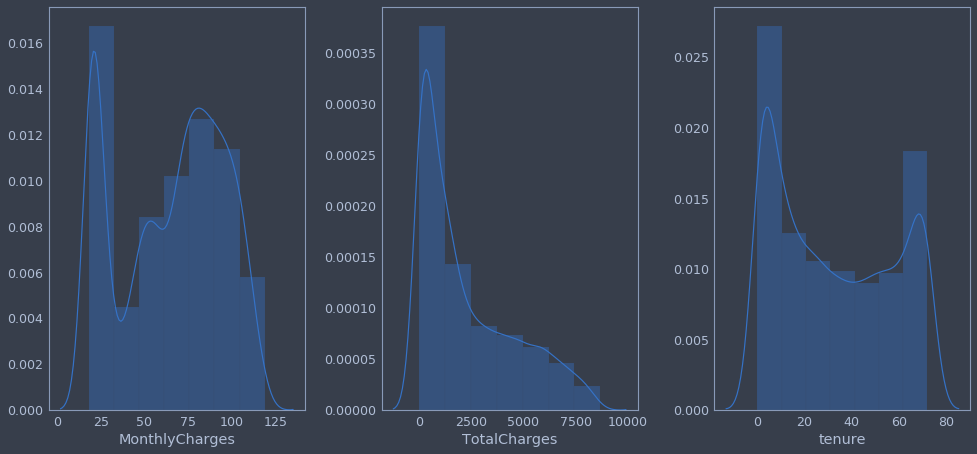

In [39]:
plt.subplots_adjust(left=1, bottom=1, right=3, top=2, wspace=.3, hspace=None)
plt.subplot(1,3,1)
sns.distplot(df['MonthlyCharges'], bins = 7)
plt.subplot(1,3,2)
sns.distplot(df['TotalCharges'], bins = 7)
plt.subplot(1,3,3)
sns.distplot(df['tenure'], bins = 7)

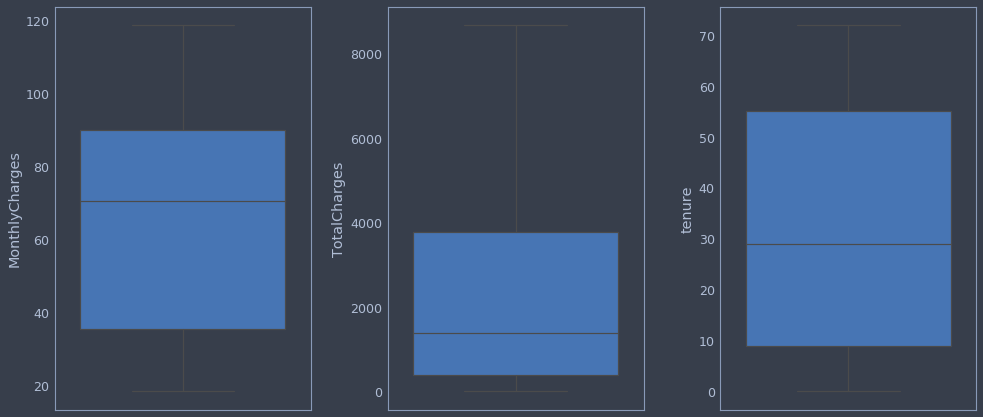

In [40]:
plt.subplots_adjust(left=1, bottom=1, right=3, top=2, wspace=.3, hspace=None)
plt.subplot(1, 3, 1)
sns.boxplot(y=df['MonthlyCharges'])
plt.subplot(1, 3, 2)
sns.boxplot(y=df['TotalCharges'])
plt.subplot(1, 3, 3)
sns.boxplot(y=df['tenure'])
plt.show()

### Feature Engineering
#### Collinearity
**TotalCharges** has a linear relationship to both **tenure** and **MonthlyCharges**, which makes sense since someone with high tenure would be charged more over time and a customer has high monthly charges, that will increase the total charges.

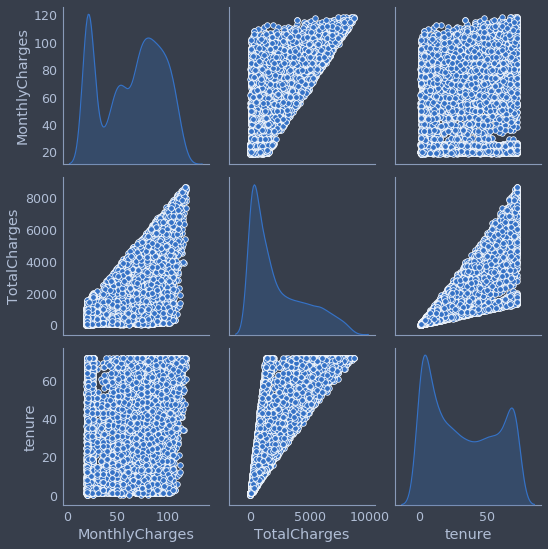

In [41]:
sns.pairplot(df[['MonthlyCharges', 'TotalCharges', 'tenure']], diag_kind = 'kde')

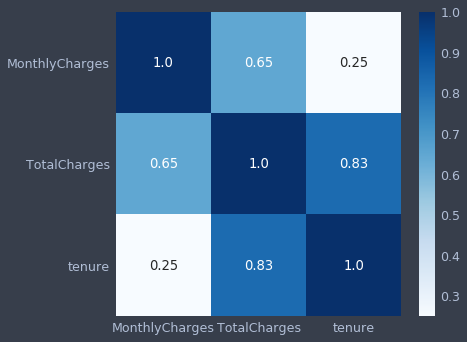

In [42]:
corr = df[['MonthlyCharges', 'TotalCharges', 'tenure']].corr().round(2)
sns.heatmap(corr,fmt='', annot=True, cmap='Blues')

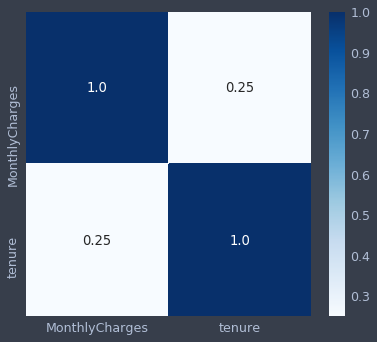

In [43]:
# remove TotalCharges since it's highly correlated with tenure and MonthlyCharges
df = df.drop('TotalCharges', 1)
corr = df[['MonthlyCharges', 'tenure']].corr().round(2)
sns.heatmap(corr,fmt='', annot=True, cmap='Blues')

Prepare the features for inital analysis

In [44]:
# encode categorical features
le = LabelEncoder()
X = df.drop('Churn', 1).apply(le.fit_transform)
y = df.Churn

# prepare target variable 'Churn' for decision tree model
y.replace('Yes', 1, inplace = True)
y.replace('No', 0, inplace = True)

Some of the most important categorical features are **Contract**, **OnlineSecurity**, **PaymentMethod**, and **TechSupport**. OnlineSecurity and TechSupport both have a level for No internet service, which could be combined with the No level.

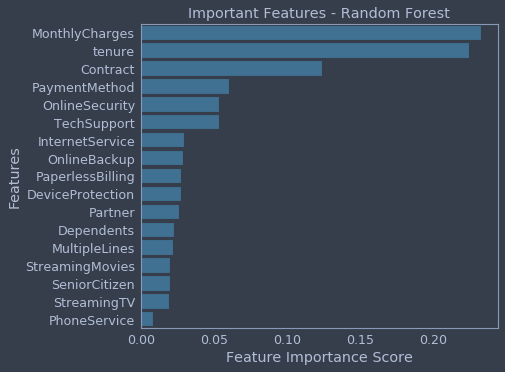

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
clf = RandomForestClassifier(class_weight='balanced', 
                           n_estimators=100).fit(X_train,y_train)

feature_imp = pd.DataFrame(clf.feature_importances_, index=X.columns)
feature_imp = feature_imp[0].sort_values(ascending=False)

sns.barplot(x=feature_imp[:20], y=feature_imp[:20].index, color = '#3274A1')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Important Features - Random Forest")
plt.legend()
plt.show()

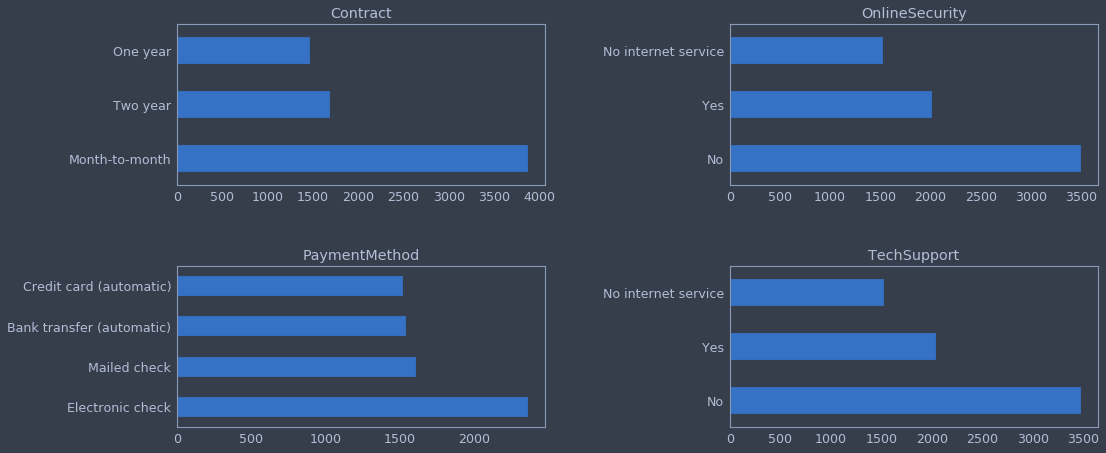

In [46]:
fig, axes = plt.subplots(nrows=2, ncols=2)
plt.subplots_adjust(left=1, bottom=1, right=3, top=2, wspace=.5, hspace=.5)
df.Contract.value_counts().plot(kind = 'barh', ax = axes[0,0], title = 'Contract')
df.OnlineSecurity.value_counts().plot(kind = 'barh', ax = axes[0,1], title = 'OnlineSecurity')
df.PaymentMethod.value_counts().plot(kind = 'barh', ax = axes[1,0], title = 'PaymentMethod')
df.TechSupport.value_counts().plot(kind = 'barh', ax = axes[1,1], title = 'TechSupport')

The dataset is a little imbalanced with 27% of the target (**Churn**) being positive. 

In [47]:
print(round(100. * df.Churn.value_counts() / len(df.Churn)))

0    73.0
1    27.0
Name: Churn, dtype: float64


The number of features can be reduced by identifying feature clusters. In the 5 cluster set, the 2nd cluster of features were not very important according to the random forest modeled above. Therefore, I'll consolidate the features to 4 clusters and use **Contract** as the most important feature in cluster 1.

In [48]:
def cluster_features(n):
    agglo = cluster.FeatureAgglomeration(n_clusters = n)
    agglo.fit(X)
    for i, label in enumerate(set(agglo.labels_)):
        features_with_label = [j for j, lab in enumerate(agglo.labels_) if lab == label]
        clustered_features = []
        for feature in features_with_label:
            clustered_features.append(X.columns[feature])
        print('Cluster {}: {}'.format(i + 1, clustered_features))

print('5 Clusters')
cluster_features(5)
print('\n4 Clusters')
cluster_features(4)

clustered_features = ['Contract', 'MonthlyCharges', 'tenure', 'PaymentMethod']

5 Clusters
Cluster 1: ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract']
Cluster 2: ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'PaperlessBilling']
Cluster 3: ['tenure']
Cluster 4: ['PaymentMethod']
Cluster 5: ['MonthlyCharges']

4 Clusters
Cluster 1: ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling']
Cluster 2: ['MonthlyCharges']
Cluster 3: ['tenure']
Cluster 4: ['PaymentMethod']


### Interaction Features
153 interaction terms are identified

In [49]:
#generating interaction terms
x_interaction = PolynomialFeatures(2, interaction_only=True, include_bias=False).fit(X)
interaction_df = pd.DataFrame(x_interaction.transform(X), columns = x_interaction.get_feature_names(X.columns))
interaction_model = linear_model.OLS(y, interaction_df).fit()

X = interaction_df
len(X.columns)

153

### Feature Importance
After creating interaction features, 25 features are significant at the .05 level, while 19 are significant at the .01 level.

In [50]:
interaction_pvalues_05 = interaction_model.pvalues[interaction_model.pvalues < 0.05].sort_values(ascending=True)
interaction_pvalues_01 = interaction_model.pvalues[interaction_model.pvalues < 0.01].sort_values(ascending=True)
interaction_features_05 = interaction_pvalues_05.index[:]
interaction_features_01 = interaction_pvalues_01.index[:]
print(len(interaction_features_05))
print(len(interaction_features_01))

25
19


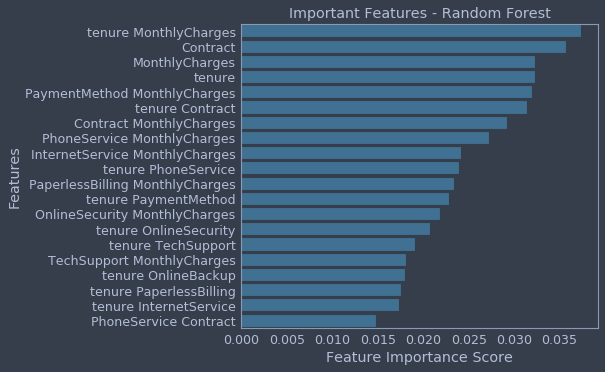

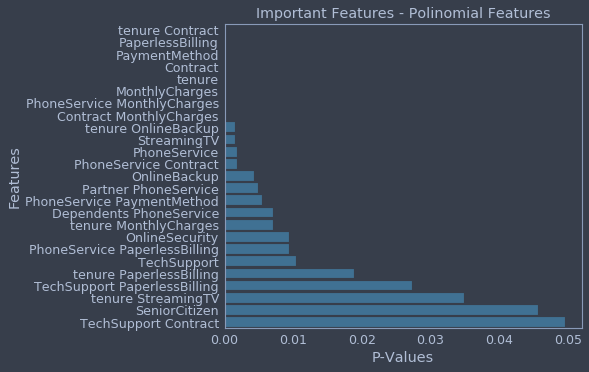

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
clf = RandomForestClassifier(class_weight='balanced', 
                           n_estimators=100).fit(X_train,y_train)

feature_imp = pd.DataFrame(clf.feature_importances_, index=X.columns)
feature_imp = feature_imp[0].sort_values(ascending=False)

sns.barplot(x=feature_imp[:20], y=feature_imp[:20].index, color = '#3274A1')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Important Features - Random Forest")
plt.legend()
plt.show()

sns.barplot(x=interaction_pvalues_05, y=interaction_features_05, color = '#3274A1')
plt.xlabel('P-Values')
plt.ylabel('Features')
plt.title("Important Features - Polinomial Features")
plt.legend()
plt.show()


In [52]:
# improve performance by limiting to the most important features
X_regduced = X[interaction_features_05] 

# Dummy variables for logistic regression
X_dummy = pd.get_dummies(X, drop_first = True)
X_dummy_reduced = pd.get_dummies(X[interaction_features_05], drop_first = True)

<Figure size 460.8x403.2 with 0 Axes>

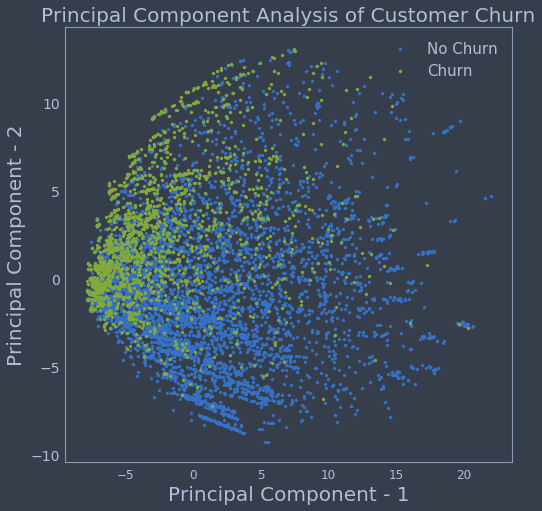

In [53]:
scaler = StandardScaler()
scaler.fit(X)
scaled_X = scaler.transform(X)

pca = PCA(n_components=2)
pca_X = pca.fit(scaled_X).transform(scaled_X)

plt.figure()
plt.figure(figsize=(8,8))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Customer Churn",fontsize=20)
targets = [0, 1]
for target in targets:
    indicesToKeep = df['Churn'] == target
    plt.scatter(pca_X.loc[indicesToKeep, 0]
               , pca_X.loc[indicesToKeep, 1], cmap = 'coolwarm', s = 10)


plt.legend(['No Churn', 'Churn'],prop={'size': 15})

## Model Evaluation

In [54]:
def create_confusion_matrix(y_test, y_pred, predicted_proba, title):
    cf_matrix = confusion_matrix(y_test, y_pred)

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    plt.title(title + 
              '\nRecall ' + str(round(recall_score(y_test, y_pred), 2)) +
              '\nPrecision ' + str(round(precision_score(y_test, y_pred), 2)) + 
              '\nAUC ' + str(round(roc_auc_score(y_test, predicted_proba[:,1]), 2)) +
              '\nF1 ' + str(round(f1_score(y_test, y_pred), 2)) +
              '\nAccuracy ' + str(round(accuracy_score(y_test, y_pred), 2)))
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')


### SVM

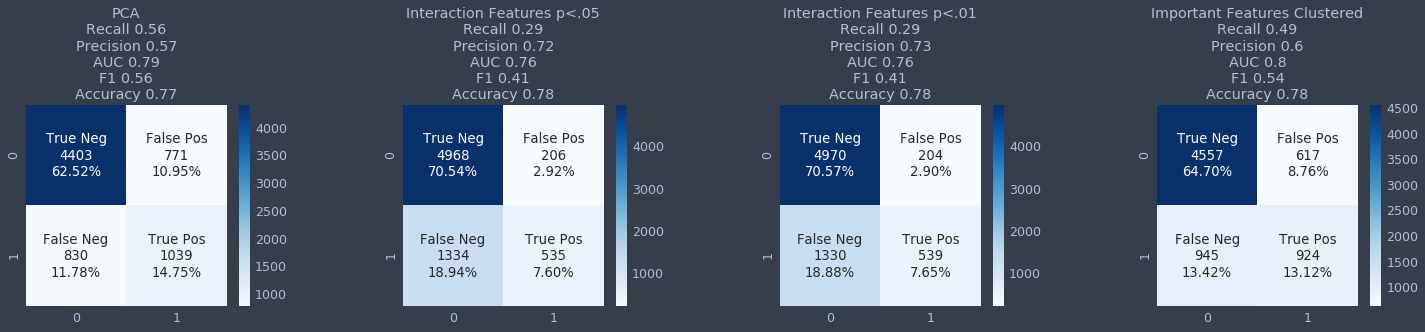

In [55]:
svm = SVC(class_weight='balanced', probability=True)

plt.subplots_adjust(left=1, bottom=.5, right=4, top=1, wspace=.5, hspace=None)

plt.subplot(1, 4, 1)
predicted_proba = cross_val_predict(svm, pca_X, y, cv=5, method='predict_proba')
y_pred = (predicted_proba[:,1] >= 0.5).astype('int')
create_confusion_matrix(y, y_pred, predicted_proba, 'PCA')

plt.subplot(1, 4, 2)
predicted_proba = cross_val_predict(svm, X[interaction_features_05], y, cv=5, method='predict_proba')
y_pred = (predicted_proba[:,1] >= 0.5).astype('int')
create_confusion_matrix(y, y_pred, predicted_proba, 'Interaction Features p<.05')

plt.subplot(1, 4, 3)
predicted_proba = cross_val_predict(svm, X[interaction_features_01], y, cv=5, method='predict_proba')
y_pred = (predicted_proba[:,1] >= 0.5).astype('int')
create_confusion_matrix(y, y_pred, predicted_proba, 'Interaction Features p<.01')

plt.subplot(1, 4, 4)
predicted_proba = cross_val_predict(svm, X[clustered_features], y, method='predict_proba')
y_pred = (predicted_proba[:,1] >= 0.5).astype('int')
create_confusion_matrix(y, y_pred, predicted_proba, 'Important Features Clustered')

### Logistic Regression

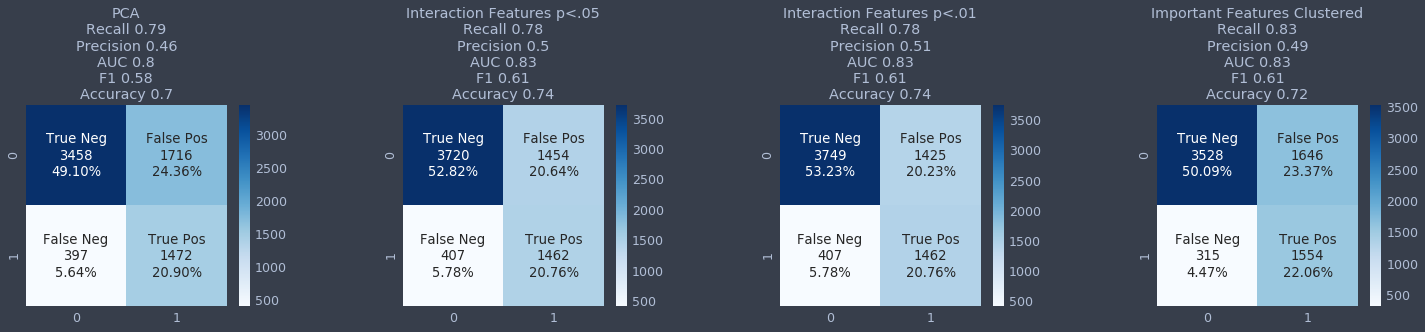

In [56]:
lr = LogisticRegression(class_weight='balanced', 
                            max_iter=1000)

plt.subplots_adjust(left=1, bottom=.5, right=4, top=1, wspace=.5, hspace=None)

plt.subplot(1, 4, 1)
predicted_proba = cross_val_predict(lr, pca_X, y, cv=5, method='predict_proba')
y_pred = (predicted_proba[:,1] >= 0.5).astype('int')
create_confusion_matrix(y, y_pred, predicted_proba, 'PCA')

plt.subplot(1, 4, 2)
predicted_proba = cross_val_predict(lr, X[interaction_features_05], y, cv=5, method='predict_proba')
y_pred = (predicted_proba[:,1] >= 0.5).astype('int')
create_confusion_matrix(y, y_pred, predicted_proba, 'Interaction Features p<.05')

plt.subplot(1, 4, 3)
predicted_proba = cross_val_predict(lr, X[interaction_features_01], y, cv=5, method='predict_proba')
y_pred = (predicted_proba[:,1] >= 0.5).astype('int')
create_confusion_matrix(y, y_pred, predicted_proba, 'Interaction Features p<.01')

plt.subplot(1, 4, 4)
predicted_proba = cross_val_predict(lr, X[clustered_features], y, method='predict_proba')
y_pred = (predicted_proba[:,1] >= 0.5).astype('int')
create_confusion_matrix(y, y_pred, predicted_proba, 'Important Features Clustered')

### Random Forest

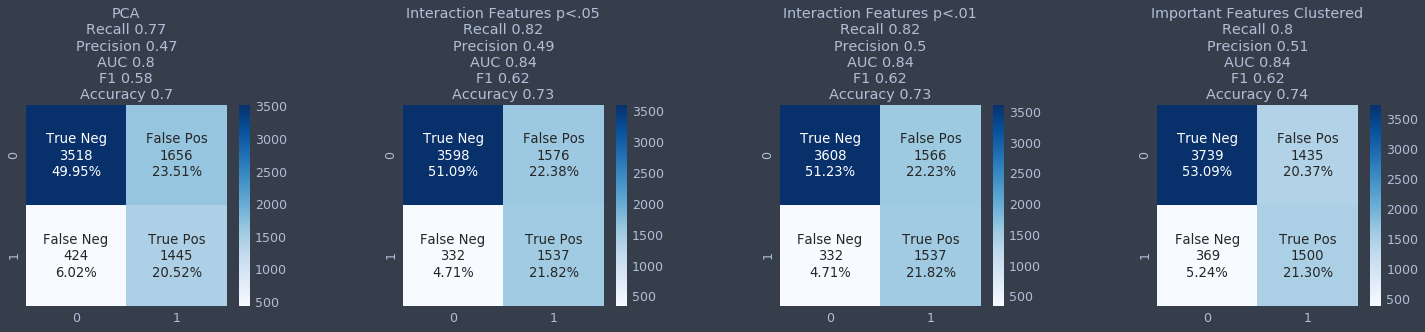

In [57]:
rf = RandomForestClassifier(class_weight='balanced', 
                               max_depth=5, 
                               n_estimators=50)

plt.subplots_adjust(left=1, bottom=.5, right=4, top=1, wspace=.5, hspace=None)

plt.subplot(1, 4, 1)
predicted_proba = cross_val_predict(rf, pca_X, y, method='predict_proba')
y_pred = (predicted_proba[:,1] >= 0.5).astype('int')
create_confusion_matrix(y, y_pred, predicted_proba, 'PCA')

plt.subplot(1, 4, 2)
predicted_proba = cross_val_predict(rf, X[interaction_features_05], y, method='predict_proba')
y_pred = (predicted_proba[:,1] >= 0.5).astype('int')
create_confusion_matrix(y, y_pred, predicted_proba, 'Interaction Features p<.05')

plt.subplot(1, 4, 3)
predicted_proba = cross_val_predict(rf, X[interaction_features_01], y, method='predict_proba')
y_pred = (predicted_proba[:,1] >= 0.5).astype('int')
create_confusion_matrix(y, y_pred, predicted_proba, 'Interaction Features p<.01')

plt.subplot(1, 4, 4)
predicted_proba = cross_val_predict(rf, X[clustered_features], y, method='predict_proba')
y_pred = (predicted_proba[:,1] >= 0.5).astype('int')
create_confusion_matrix(y, y_pred, predicted_proba, 'Important Features Clustered')

## Model Comparison

The SVM models are significantly slower and perform worse than the logistic regression and random forest models.

In [58]:
model_params = {
    'logistic_regression': {
        'model': LogisticRegression(class_weight = 'balanced', max_iter=1000),
        'params': {
            'C': range(1, 20)
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(class_weight = 'balanced'),
        'params': {
            'max_depth': range(1, 20),
            'n_estimators': range(1, 100)
        }
    }
}

scores = []

from sklearn.model_selection import RandomizedSearchCV

for model_name, mp in model_params.items():
    clf = RandomizedSearchCV(mp['model'], mp['params'], scoring = 'roc_auc', return_train_score = False)
    clf.fit(X[interaction_features_01], y)
    scores.append({
        'model': model_name,
        'best_auc_score': clf.best_score_,
#         'results': clf.cv_results_
        'best_params': clf.best_params_
    })
    
for model_name, mp in model_params.items():
    clf = RandomizedSearchCV(mp['model'], mp['params'], scoring = 'recall', return_train_score = False)
    clf.fit(X[interaction_features_01], y)
    scores.append({
        'model': model_name,
        'best_recall_score': clf.best_score_,
#         'results': clf.cv_results_
        'best_params': clf.best_params_
    })

Let's do a sanity check and see if we can find a better model with hyperparameter tuning.

In [59]:
scores

[{'model': 'logistic_regression',
  'best_auc_score': 0.8300187441641798,
  'best_params': {'C': 1}},
 {'model': 'random_forest',
  'best_auc_score': 0.8420068983595208,
  'best_params': {'n_estimators': 76, 'max_depth': 7}},
 {'model': 'logistic_regression',
  'best_recall_score': 0.7832948631560838,
  'best_params': {'C': 7}},
 {'model': 'random_forest',
  'best_recall_score': 0.8854955484509184,
  'best_params': {'n_estimators': 58, 'max_depth': 1}}]

## Conclusion
The model that performed the best was the random forest with interaction features significant at the .01 level. This model maximized recall, while minimizing the loss of precision and had the maximum AUC and F1 scores.

In [60]:
# chosen features
print(interaction_features_01)
print(len(interaction_features_01))

Index(['tenure Contract', 'PaperlessBilling', 'PaymentMethod', 'Contract',
       'tenure', 'MonthlyCharges', 'PhoneService MonthlyCharges',
       'Contract MonthlyCharges', 'tenure OnlineBackup', 'StreamingTV',
       'PhoneService', 'PhoneService Contract', 'OnlineBackup',
       'Partner PhoneService', 'PhoneService PaymentMethod',
       'Dependents PhoneService', 'tenure MonthlyCharges', 'OnlineSecurity',
       'PhoneService PaperlessBilling'],
      dtype='object')
19


Depending on the cost of marketing materials, a higher or lower recall may be desirable and can be obtained by adjusting the .05 threshold.

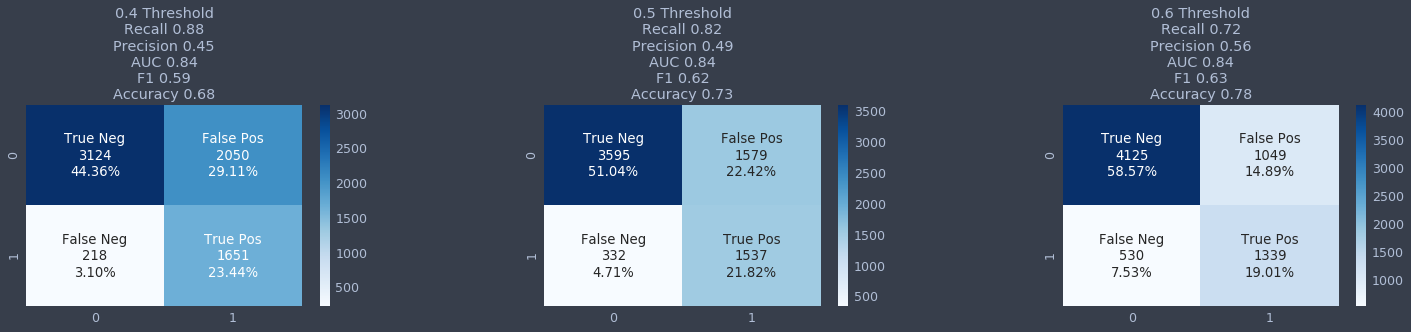

In [61]:
plt.subplots_adjust(left=1, bottom=.5, right=4, top=1, wspace=.5, hspace=None)

for i in range(3):
    threshold = round((i / 10) + 0.4, 1)
    plt.subplot(1, 3, i + 1)
    predicted_proba = cross_val_predict(rf, X[interaction_features_01], y, method='predict_proba')
    y_pred = (predicted_proba[:,1] >= threshold).astype('int')
    create_confusion_matrix(y, y_pred, predicted_proba, str(threshold) + ' Threshold')